In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score, confusion_matrix
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [2]:
df = pd.read_csv('address_data_combined.csv')
print(df['FLAG'].value_counts())
df = df.loc[~(df.iloc[:, 2:14] == 0).all(axis=1)]
print(df['FLAG'].value_counts())
df.head()

FLAG
0    7637
1    6518
Name: count, dtype: int64
FLAG
0    7637
1    4616
Name: count, dtype: int64


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract),total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342
6,0x83915e4ff807ba28b53931f923247c9fa0147eb9,1,212.63,59.16,3746.00,12,0.000008,0.317522,0.037252,0.000000,0.937929,27,0.484270,-12.646730


In [3]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(8577, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract),total ether received,total ether balance
14152,2499.44,2189.29,261601.88,31,0.001078,21.310000,1.234192,0.004000,0.922179,110,53.070252,-8.715743
9201,554.51,5056.92,359311.30,14,0.033000,200.009160,14.102530,0.000000,5.119914,242,705.126492,-277.896991
9725,0.00,13.69,17083.50,2,0.001000,1.000000,0.500500,1.000958,1.000958,3,1.001000,0.000042
9739,0.00,1905.57,226763.42,3,0.000000,0.889347,0.379140,0.000000,0.000000,120,45.117655,45.117655
11837,0.00,0.00,2.38,1,0.407916,0.407916,0.407916,0.407444,0.407444,2,0.407916,0.000472


In [4]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract)',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
  X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)
columns = X_train_full.columns

# Scaling
# only use training data to fit, to avoid data leakage
# Not required for Naive Bayes but performed to ensure all variables are standardized through all ML models
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
# params = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "num_leaves": [20, 50, 100, 500, 1000],
#     "max_depth": [i for i in range(3, 12)],
#     "max_bin": [200, 300],
#     "min_gain_to_split": [i for i in range(0, 15, 5)],
#     "bagging_fraction": [0.2, 0.3, 0.5, 0.7, 0.95],
#     "bagging_freq": [1],
#     "feature_fraction": [0.2, 0.3, 0.5, 0.7, 0.95]
# }


#optimized
params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [20, 50, 100],
    "max_depth": [3, 6, 9],
    "max_bin": [200, 300],
    "min_split_gain": [0, 5, 10],  # ✅ Fixed name
    "subsample": [0.5, 0.7, 0.9],  # ✅ Fixed name
    "subsample_freq": [1],         # ✅ Fixed name
    "colsample_bytree": [0.5, 0.7, 0.9]  # ✅ Fixed name
}



In [18]:
clf = lgb.LGBMClassifier()

# tuned_clf = GridSearchCV(estimator=clf,
#                          param_grid=params,
#                          scoring='f1',
#                          cv=5,
#                          verbose=0,
#                          )

#optimized
tuned_clf = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    n_iter=20  # Limits the number of parameter combinations tested
)

In [32]:
import warnings
warnings.filterwarnings("ignore")
tuned_clf.fit(X_train_full,y_train_full)
print("Best hyperparameters:", tuned_clf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 3231, number of negative: 5346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3458
[LightGBM] [Info] Number of data points in the train set: 8577, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376705 -> initscore=-0.503557
[LightGBM] [Info] Start training from score -0.503557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best hyperparameters: {'subsample_freq': 1, 'subsample': 0.5, 'num_leaves': 50, 'min_split_gain': 0, 'max_depth': 9, 'max_bin': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


In [33]:
y_train_pred = tuned_clf.predict(X_train_full)
y_test_pred = tuned_clf.predict(X_test)

# Compute F1-scores
train_f1 = f1_score(y_train_full, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Train F1 Score: 0.9485
Test F1 Score: 0.8913


In [ ]:
# lightgbm_params = {"bagging_fraction": 0.95,
#                    "bagging_freq": 1,
#                    "feature_fraction": 0.95,
#                    "learning_rate": 0.2,
#                    "max_bin": 300,
#                    "max_depth": 6,
#                    "min_gain_to_split": 0,
#                    "num_leaves": 20}

# lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
# lightgbm_model.fit(X_train_full, y_train_full)

# Define parameters using canonical names
# lightgbm_params = {
#     "subsample": 0.95,  # Instead of bagging_fraction
#     "subsample_freq": 1,  # Instead of bagging_freq
#     "colsample_bytree": 0.95,  # Instead of feature_fraction
#     "learning_rate": 0.2,
#     "max_bin": 300,
#     "max_depth": 6,
#     "min_split_gain": 0,  # Instead of min_gain_to_split
#     "num_leaves": 20
# }

# Initialize and train model
# lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
# lightgbm_model.fit(X_train_full, y_train_full)

[LightGBM] [Info] Number of positive: 4562, number of negative: 5346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 9908, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460436 -> initscore=-0.158587
[LightGBM] [Info] Start training from score -0.158587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(colsample_bytree=0.95, learning_rate=0.2, max_bin=300,
               max_depth=6, min_split_gain=0, num_leaves=20, subsample=0.95,
               subsample_freq=1)

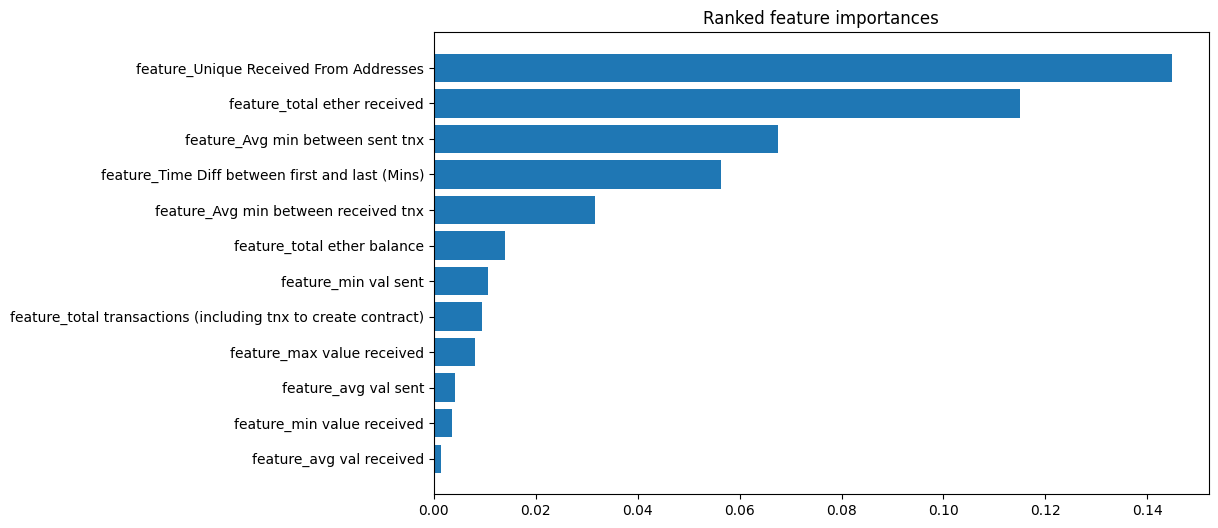

In [34]:
lightgbm_model = tuned_clf.best_estimator_ #added this line aiyu
from sklearn.inspection import permutation_importance
feat_importances = permutation_importance(lightgbm_model, X_test, y_test)['importances_mean']
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [37]:
best_y_pr = lightgbm_model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, best_y_pr))
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Accuracy Score:  0.9194776931447225
Test F1 Score:  0.8913362701908958


In [36]:
import joblib
joblib.dump(lightgbm_model, 'lightBGM_fraud_model_final.pkl')

['lightBGM_fraud_model_final.pkl']

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
import numpy as np

# Define the log transform function
def log_transform_df(X):
    X = X.copy()
    for col in X.columns:
        X[col] = X[col].apply(lambda x: np.log(x) if x > 0 else 0)
    return X

# Create the pipeline
preprocessing_pipeline = Pipeline([
    # Log-transform step (using the named function)
    ('log_transform', FunctionTransformer(log_transform_df)),
    # Scaling step (using the pre-fitted scaler)
    ('scaler', scaler)  # Use the scaler already fitted on X_train_full
])

# Save the pipeline
joblib.dump(preprocessing_pipeline, 'preprocessor.pkl')

['preprocessor.pkl']

In [39]:
import pandas as pd
import joblib
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def log_transform_df(X):
    X = X.copy()
    for col in X.columns:
        X[col] = X[col].apply(lambda x: np.log(x) if x > 0 else 0)
    return X


preprocessor = joblib.load('preprocessor.pkl')
model = joblib.load('lightBGM_fraud_model_final.pkl')

# Define a single transaction (example values)
df = pd.DataFrame({
    'Avg min between sent tnx': [6.0],
    'Avg min between received tnx': [8.33],
    'Time Diff between first and last (Mins)': [83247.35],
    'Unique Received From Addresses': [59],
    'min value received': [0.0],
    'max value received': [0.01],
    'avg val received': [0.000002],
    'min val sent': [0.0],
    'avg val sent': [0.0],
    'total transactions (including tnx to create contract)': [10000],
    'total ether received': [0.015],
    'total ether balance': [0.015]
}
)

# Preprocess and predict
npArray_processed = preprocessor.transform(df)
print(npArray_processed)
fraud_probability = model.predict_proba(npArray_processed)[:, 1][0]
print(f"Fraud Probability: {fraud_probability:.4f}")

[[0.23771843 0.37863452 0.79117545 0.44271781 0.80331637 0.27515136
  0.         0.6536654  0.59370187 0.93003327 0.26839648 0.26839648]]
Fraud Probability: 0.1260


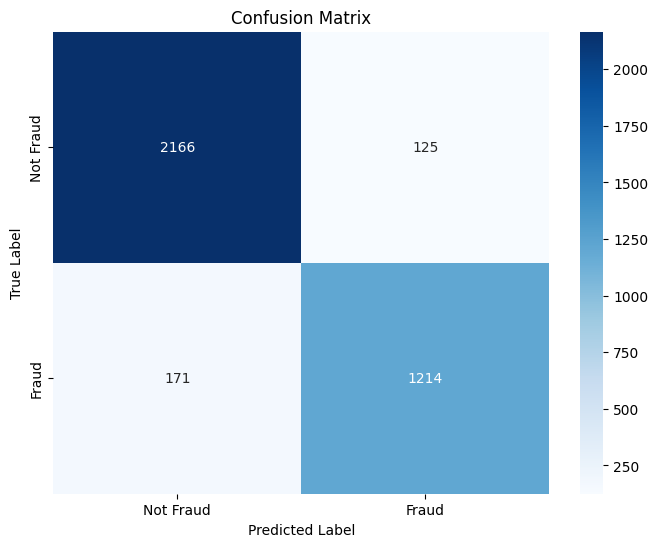


 recall: 0.8765

 false_neg_rate: 0.1235

 false_pos_rate: 0.0546

 true_neg_rate: 0.9454

 positive_liklihood_ratio: 16.0651

 neg_liklihood_rate: 0.1306

 precision: 0.9066

 false_omission_rate: 0.0732

 false_discovery_rate: 0.0934

 neg_pred_value: 0.9268

 markedness: 0.8335

 diagnostic_odds_ration: 123.0187

 informedness: 0.8220

 prevalence_threshold: 0.1997

 prevalence: 0.3768

 accuracy: 0.9195

 balanced_accuracy: 0.9110

 F1_score: 0.8913

 fowlkes_mallows_index: 0.8915

 jaccard_index: 0.8040


In [40]:
from math import sqrt
from sklearn.metrics import confusion_matrix
import joblib

model = joblib.load('lightBGM_fraud_model_final.pkl')
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
    'recall' : tp/p,
    'false_neg_rate' : fn/p,
    'false_pos_rate' : fp/n,
    'true_neg_rate' : tn/n,
    'positive_liklihood_ratio' : (tp/p)/(fp/n),
    'neg_liklihood_rate' : (fn/p)/(tn/n),
    'precision' : tp/pp,
    'false_omission_rate' : fn/pn,
    'false_discovery_rate' : fp/pp,
    'neg_pred_value' : tn/pn,
    'markedness' : (tp/pp)+(tn/pn)-1,
    'diagnostic_odds_ration' : ((tp/p)/(fp/n))/( (fn/p)/(tn/n)),
    'informedness' : (tp/p)+(tn/n)-1,
    'prevalence_threshold' : (sqrt((tp/p)*(fp/n))-(fp/n))/((tp/p)-(fp/n)),
    'prevalence' : p/(p+n),
    'accuracy' : (tp+tn)/(p+n),
    'balanced_accuracy' : ((tp/p)+(tn/n))/2,
    'F1_score' : 2*tp/(2*tp+fp+fn),
    'fowlkes_mallows_index' : sqrt((tp/pp)*(tp/p)),
    'jaccard_index' : tp/(tp+fn+fp),
    }

    return diagnostic_dict

y_pred = model.predict(X_test)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
stats = model_diagnostic_stats(cm)
for key,value in stats.items():
    value_str = '%.4f' % value
    print("\n {}: {}".format(key,value_str))


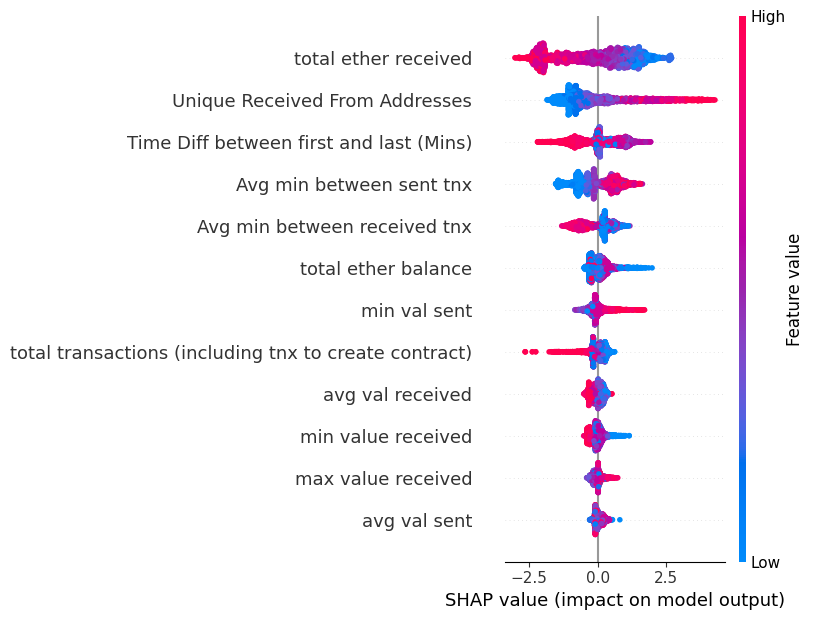

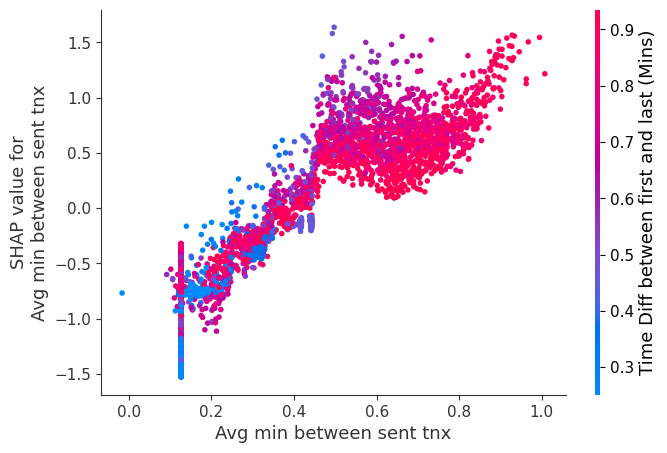

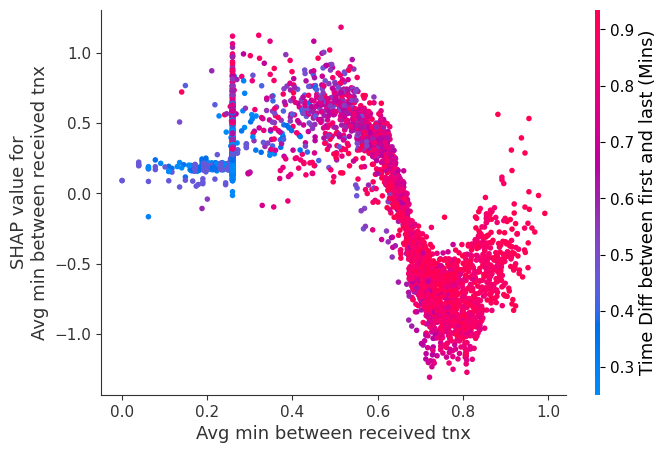

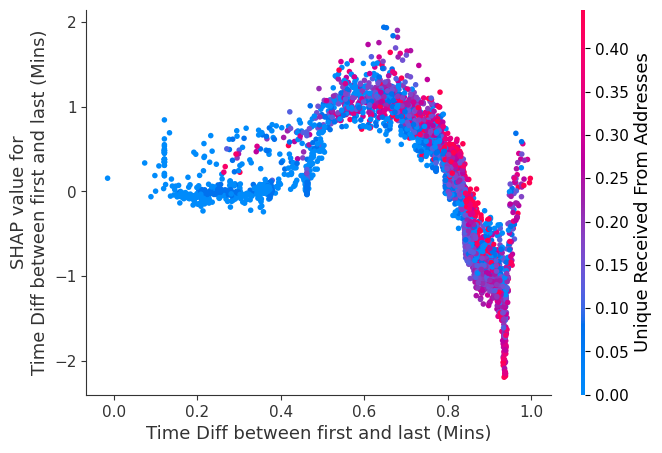

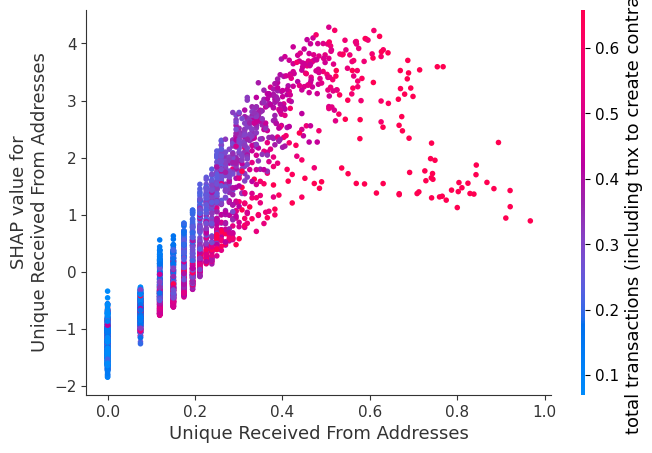

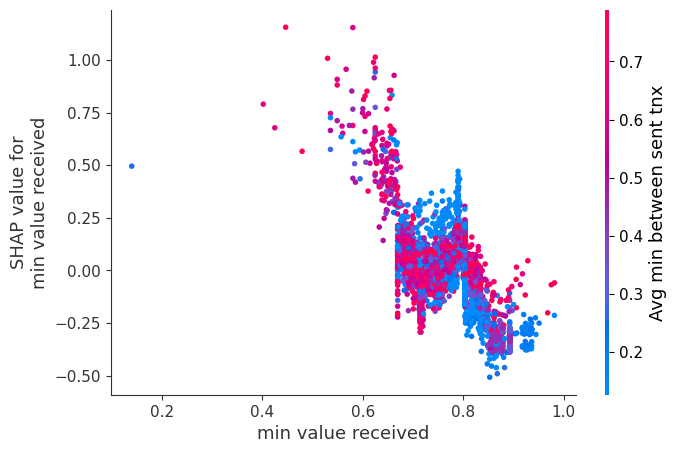

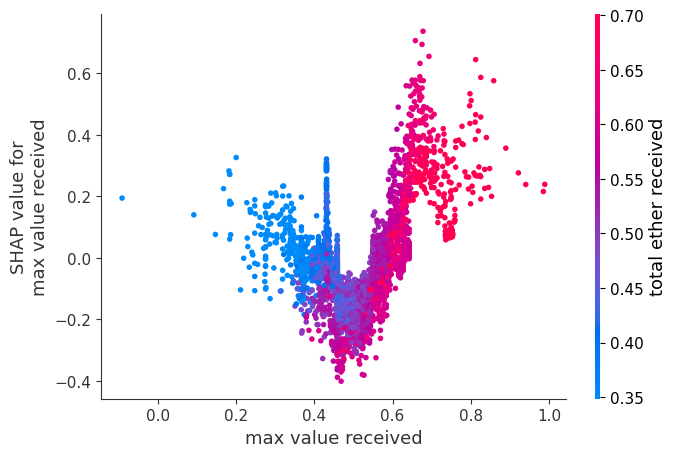

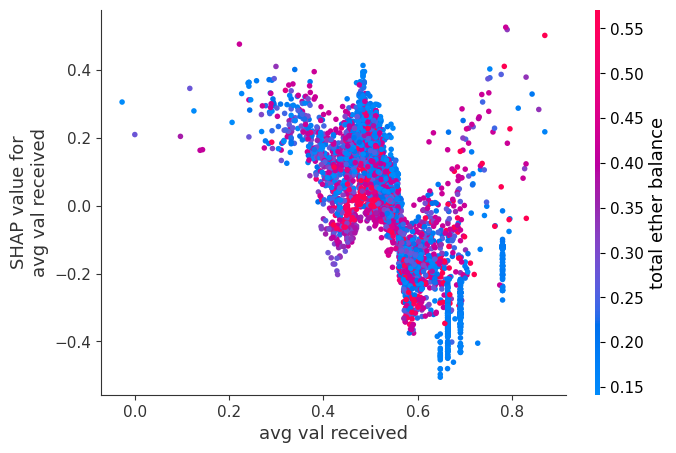

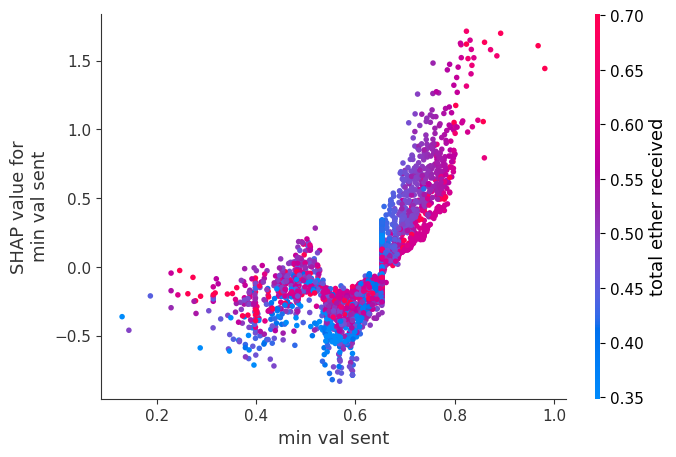

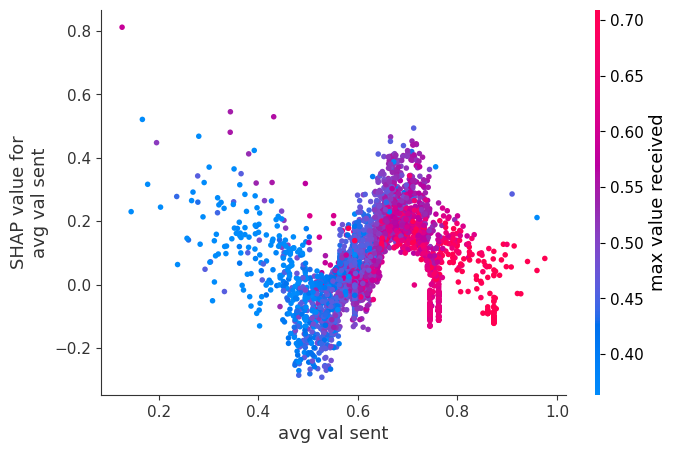

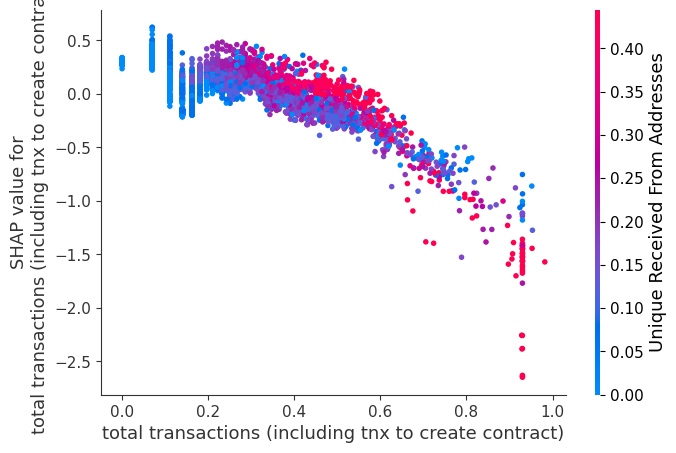

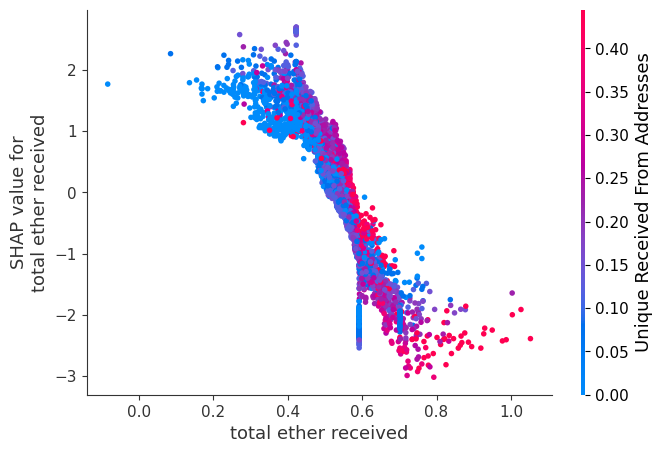

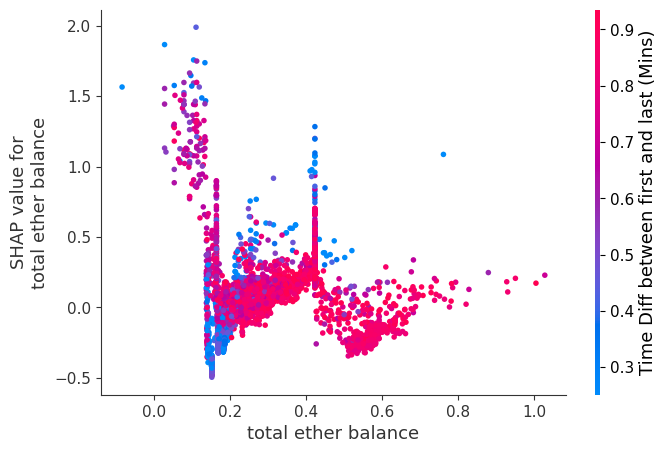

In [41]:
import shap
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Manually define feature names (MUST match training features)
feature_names = [
    "Avg min between sent tnx",
    "Avg min between received tnx",
    "Time Diff between first and last (Mins)",
    "Unique Received From Addresses",
    "min value received",
    "max value received",
    "avg val received",
    "min val sent",
    "avg val sent",
    "total transactions (including tnx to create contract)",
    "total ether received",
    "total ether balance"
]

# Convert X_test to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=feature_names)


explainer = shap.Explainer(lightgbm_model)
shap_values = explainer(X_test_df)

# Summary Plot
shap.summary_plot(shap_values, X_test_df)

# Dependence Plots
for feature in feature_names:
    shap.dependence_plot(feature, shap_values.values, X_test_df)

# Force Plot for a Single Prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_df.iloc[0])


[link text](https://)